In [1]:
from scipy import stats as st
import numpy as np

In [3]:
D = 2 # размерность пространства объектов
mu1 = np.random.random_sample(D) * 10 
H1 = np.random.random_sample((D, D))
H1 = H1.T @ H1 + 0.01*np.eye(D)
mu2 = np.random.random_sample(D) * 10 
H2 = np.random.random_sample((D, D))
H2 = H2.T @ H2 + 0.01*np.eye(D)
#H /= H.max()

In [4]:
import torch
from torch import nn

In [5]:
d = 5 # размерность латентного пространства

In [6]:
class Generator(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.block1 = nn.Sequential(
            nn.Linear(d+D, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()       
        )
        self.block2 = nn.Sequential(
            nn.Linear(d+D+256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()       
        )
        self.block3 = nn.Sequential(
            nn.Linear(d+D+512, D),
            #nn.Tanh()       
        )
    
    def forward(self, h0):
        h1 = torch.cat((h0, self.block1(h0)), dim=1)
        h2 = torch.cat((h1, self.block2(h1)), dim=1)
        return self.block3(h2)
        

class Discriminator(nn.Module):
    def __init__(self, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.D = D
        self.block1 = nn.Sequential(
            nn.Linear(D, 256),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        self.block2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        self.block3 = nn.Sequential(
            nn.Linear(256, 1),
            #nn.Sigmoid()         
        )
       
    def forward(self, h0):
        h1 = self.block1(h0)
        h2 = self.block2(h1)
        return self.block3(h2)
    
netG = Generator(d, D)
netD = Discriminator(D)

In [7]:
lr = 0.0002

# Initialize BCELoss function
criterion = nn.BCELoss()
criterion2 = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, d)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)

In [61]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, size):
        self.data = np.vstack((st.multivariate_normal.rvs(mean=mu1, cov=H1, size=size), st.multivariate_normal.rvs(mean=mu2, cov=H2, size=size))) 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
dataset = MyDataset(100000)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [72]:
clip = 0.5
def weight_clip(m):
    if type(m) == nn.Linear:
        with torch.no_grad():
            m.weight[m.weight > clip] = clip
            m.weight[m.weight < -clip] = -clip

In [98]:
num_epochs = 100
netD.train()
netG.train()

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.float()
        #print(real_data[0].dtype)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion2(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        #D_x = output.mean().item()

        if i % 5 == 0:
            ## Train with all-fake batch
            # Generate batch of latent vectors
            mask = torch.rand(data.shape).ge(0.5)
            masked_data = data.float() * mask
            noise = torch.randn(b_size, d) * 10
            # Generate fake image batch with G
            fake = netG(torch.cat((masked_data, noise), dim=1))
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion2(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
        
        if i % 3 == 0:
            label.fill_(fake_label)
            super_fake = torch.rand(fake.shape) * 30 - 10
            output2 = netD(super_fake.detach()).view(-1)
            errD_super_fake = criterion2(output2, label)
            errD_super_fake.backward()        
        
        #D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake + errD_super_fake
        # Update D
        optimizerD.step()

        if i % 5 == 0:
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion2(output, label)
            errG_gen = nn.L1Loss()(fake*mask, masked_data)
            errG += errG_gen
            # Calculate gradients for G
            errG.backward()
            #D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
        
            netD.apply(weight_clip)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            #with torch.no_grad():
                #fake = netG(fixed_noise).detach().cpu()
            #img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/782]	Loss_D: 1.8561	Loss_G: 0.2825
[0/100][50/782]	Loss_D: 1.8684	Loss_G: 0.2692
[0/100][100/782]	Loss_D: 1.8946	Loss_G: 0.2703
[0/100][150/782]	Loss_D: 1.8456	Loss_G: 0.2962
[0/100][200/782]	Loss_D: 1.9501	Loss_G: 0.2744
[0/100][250/782]	Loss_D: 1.9053	Loss_G: 0.2810
[0/100][300/782]	Loss_D: 1.9533	Loss_G: 0.2666
[0/100][350/782]	Loss_D: 1.8995	Loss_G: 0.2743
[0/100][400/782]	Loss_D: 1.9196	Loss_G: 0.2705
[0/100][450/782]	Loss_D: 1.9300	Loss_G: 0.2681
[0/100][500/782]	Loss_D: 1.9050	Loss_G: 0.2733
[0/100][550/782]	Loss_D: 1.9450	Loss_G: 0.2647
[0/100][600/782]	Loss_D: 1.9084	Loss_G: 0.2546
[0/100][650/782]	Loss_D: 1.9323	Loss_G: 0.2621
[0/100][700/782]	Loss_D: 1.8856	Loss_G: 0.2706
[0/100][750/782]	Loss_D: 1.8563	Loss_G: 0.2859
[1/100][0/782]	Loss_D: 1.9013	Loss_G: 0.2736
[1/100][50/782]	Loss_D: 1.8658	Loss_G: 0.2858
[1/100][100/782]	Loss_D: 1.9089	Loss_G: 0.2628
[1/100][150/782]	Loss_D: 1.8581	Loss_G: 0.2663
[1/100][200/782]	Loss_D: 1.9627	Loss_G: 

[10/100][750/782]	Loss_D: 1.9130	Loss_G: 0.2694
[11/100][0/782]	Loss_D: 1.9100	Loss_G: 0.2641
[11/100][50/782]	Loss_D: 1.9188	Loss_G: 0.3007
[11/100][100/782]	Loss_D: 1.9211	Loss_G: 0.2558
[11/100][150/782]	Loss_D: 1.8368	Loss_G: 0.2803
[11/100][200/782]	Loss_D: 1.9232	Loss_G: 0.2776
[11/100][250/782]	Loss_D: 1.8980	Loss_G: 0.2687
[11/100][300/782]	Loss_D: 1.9028	Loss_G: 0.2513
[11/100][350/782]	Loss_D: 1.9043	Loss_G: 0.2531
[11/100][400/782]	Loss_D: 1.8968	Loss_G: 0.2698
[11/100][450/782]	Loss_D: 1.9805	Loss_G: 0.2611
[11/100][500/782]	Loss_D: 1.8439	Loss_G: 0.2746
[11/100][550/782]	Loss_D: 1.8638	Loss_G: 0.2717
[11/100][600/782]	Loss_D: 1.8876	Loss_G: 0.2691
[11/100][650/782]	Loss_D: 1.9015	Loss_G: 0.2562
[11/100][700/782]	Loss_D: 1.8828	Loss_G: 0.2656
[11/100][750/782]	Loss_D: 1.9016	Loss_G: 0.2667
[12/100][0/782]	Loss_D: 1.8709	Loss_G: 0.2762
[12/100][50/782]	Loss_D: 1.8622	Loss_G: 0.2703
[12/100][100/782]	Loss_D: 1.9320	Loss_G: 0.2613
[12/100][150/782]	Loss_D: 1.8304	Loss_G: 0.273

[21/100][550/782]	Loss_D: 1.8759	Loss_G: 0.2805
[21/100][600/782]	Loss_D: 1.9197	Loss_G: 0.2730
[21/100][650/782]	Loss_D: 1.9858	Loss_G: 0.2530
[21/100][700/782]	Loss_D: 1.8836	Loss_G: 0.2761
[21/100][750/782]	Loss_D: 1.8540	Loss_G: 0.2829
[22/100][0/782]	Loss_D: 1.8852	Loss_G: 0.2803
[22/100][50/782]	Loss_D: 1.8714	Loss_G: 0.2754
[22/100][100/782]	Loss_D: 1.8992	Loss_G: 0.2786
[22/100][150/782]	Loss_D: 1.9307	Loss_G: 0.2589
[22/100][200/782]	Loss_D: 1.8542	Loss_G: 0.2782
[22/100][250/782]	Loss_D: 1.8773	Loss_G: 0.2811
[22/100][300/782]	Loss_D: 1.9400	Loss_G: 0.2708
[22/100][350/782]	Loss_D: 1.8918	Loss_G: 0.2769
[22/100][400/782]	Loss_D: 1.9218	Loss_G: 0.2603
[22/100][450/782]	Loss_D: 1.9193	Loss_G: 0.2709
[22/100][500/782]	Loss_D: 1.8584	Loss_G: 0.2744
[22/100][550/782]	Loss_D: 1.9338	Loss_G: 0.2656
[22/100][600/782]	Loss_D: 1.8929	Loss_G: 0.2829
[22/100][650/782]	Loss_D: 1.9075	Loss_G: 0.2655
[22/100][700/782]	Loss_D: 1.8963	Loss_G: 0.2727
[22/100][750/782]	Loss_D: 1.8736	Loss_G: 0.

[32/100][350/782]	Loss_D: 1.9297	Loss_G: 0.2814
[32/100][400/782]	Loss_D: 1.9483	Loss_G: 0.2700
[32/100][450/782]	Loss_D: 1.8628	Loss_G: 0.2836
[32/100][500/782]	Loss_D: 1.8758	Loss_G: 0.2628
[32/100][550/782]	Loss_D: 1.8890	Loss_G: 0.2912
[32/100][600/782]	Loss_D: 1.8637	Loss_G: 0.2870
[32/100][650/782]	Loss_D: 1.9476	Loss_G: 0.2525
[32/100][700/782]	Loss_D: 1.8445	Loss_G: 0.2831
[32/100][750/782]	Loss_D: 1.8800	Loss_G: 0.2715
[33/100][0/782]	Loss_D: 1.8827	Loss_G: 0.2736
[33/100][50/782]	Loss_D: 1.8720	Loss_G: 0.2809
[33/100][100/782]	Loss_D: 1.8945	Loss_G: 0.2679
[33/100][150/782]	Loss_D: 1.8468	Loss_G: 0.2780
[33/100][200/782]	Loss_D: 1.8343	Loss_G: 0.2771
[33/100][250/782]	Loss_D: 1.8923	Loss_G: 0.2779
[33/100][300/782]	Loss_D: 1.9091	Loss_G: 0.2546
[33/100][350/782]	Loss_D: 1.8905	Loss_G: 0.2664
[33/100][400/782]	Loss_D: 1.9353	Loss_G: 0.2549
[33/100][450/782]	Loss_D: 1.9015	Loss_G: 0.2703
[33/100][500/782]	Loss_D: 1.9151	Loss_G: 0.2612
[33/100][550/782]	Loss_D: 1.8983	Loss_G: 0.

[43/100][150/782]	Loss_D: 1.9052	Loss_G: 0.2628
[43/100][200/782]	Loss_D: 1.9209	Loss_G: 0.2603
[43/100][250/782]	Loss_D: 1.8932	Loss_G: 0.2670
[43/100][300/782]	Loss_D: 1.9210	Loss_G: 0.2778
[43/100][350/782]	Loss_D: 1.8899	Loss_G: 0.2813
[43/100][400/782]	Loss_D: 1.9103	Loss_G: 0.2568
[43/100][450/782]	Loss_D: 1.9209	Loss_G: 0.2684
[43/100][500/782]	Loss_D: 1.9149	Loss_G: 0.2635
[43/100][550/782]	Loss_D: 1.8868	Loss_G: 0.2664
[43/100][600/782]	Loss_D: 1.9176	Loss_G: 0.2546
[43/100][650/782]	Loss_D: 1.8666	Loss_G: 0.2804
[43/100][700/782]	Loss_D: 1.9011	Loss_G: 0.2799
[43/100][750/782]	Loss_D: 1.8757	Loss_G: 0.2640
[44/100][0/782]	Loss_D: 1.8908	Loss_G: 0.2775
[44/100][50/782]	Loss_D: 1.8087	Loss_G: 0.2869
[44/100][100/782]	Loss_D: 1.8780	Loss_G: 0.2857
[44/100][150/782]	Loss_D: 1.8762	Loss_G: 0.2683
[44/100][200/782]	Loss_D: 1.9211	Loss_G: 0.2490
[44/100][250/782]	Loss_D: 1.8964	Loss_G: 0.2687
[44/100][300/782]	Loss_D: 1.9012	Loss_G: 0.2475
[44/100][350/782]	Loss_D: 1.8694	Loss_G: 0.

[53/100][750/782]	Loss_D: 1.9118	Loss_G: 0.2654
[54/100][0/782]	Loss_D: 1.8566	Loss_G: 0.2787
[54/100][50/782]	Loss_D: 1.8976	Loss_G: 0.2769
[54/100][100/782]	Loss_D: 1.9051	Loss_G: 0.2758
[54/100][150/782]	Loss_D: 1.9082	Loss_G: 0.2627
[54/100][200/782]	Loss_D: 1.8264	Loss_G: 0.2980
[54/100][250/782]	Loss_D: 1.8633	Loss_G: 0.2760
[54/100][300/782]	Loss_D: 1.9059	Loss_G: 0.2671
[54/100][350/782]	Loss_D: 1.8675	Loss_G: 0.2805
[54/100][400/782]	Loss_D: 1.8975	Loss_G: 0.2678
[54/100][450/782]	Loss_D: 1.9256	Loss_G: 0.2683
[54/100][500/782]	Loss_D: 1.8865	Loss_G: 0.2648
[54/100][550/782]	Loss_D: 1.8816	Loss_G: 0.2749
[54/100][600/782]	Loss_D: 1.8151	Loss_G: 0.2872
[54/100][650/782]	Loss_D: 1.8991	Loss_G: 0.2833
[54/100][700/782]	Loss_D: 1.9554	Loss_G: 0.2545
[54/100][750/782]	Loss_D: 1.9483	Loss_G: 0.2571
[55/100][0/782]	Loss_D: 1.8782	Loss_G: 0.2614
[55/100][50/782]	Loss_D: 1.8258	Loss_G: 0.2828
[55/100][100/782]	Loss_D: 1.8789	Loss_G: 0.2878
[55/100][150/782]	Loss_D: 1.9218	Loss_G: 0.270

[64/100][550/782]	Loss_D: 1.9172	Loss_G: 0.2598
[64/100][600/782]	Loss_D: 1.9252	Loss_G: 0.2560
[64/100][650/782]	Loss_D: 1.9572	Loss_G: 0.2625
[64/100][700/782]	Loss_D: 1.8839	Loss_G: 0.2782
[64/100][750/782]	Loss_D: 1.9208	Loss_G: 0.2606
[65/100][0/782]	Loss_D: 1.9542	Loss_G: 0.2605
[65/100][50/782]	Loss_D: 1.8693	Loss_G: 0.2727
[65/100][100/782]	Loss_D: 1.8693	Loss_G: 0.2984
[65/100][150/782]	Loss_D: 1.8570	Loss_G: 0.2656
[65/100][200/782]	Loss_D: 1.9040	Loss_G: 0.2507
[65/100][250/782]	Loss_D: 1.8927	Loss_G: 0.2811
[65/100][300/782]	Loss_D: 1.8259	Loss_G: 0.2663
[65/100][350/782]	Loss_D: 1.8908	Loss_G: 0.2567
[65/100][400/782]	Loss_D: 1.8863	Loss_G: 0.2723
[65/100][450/782]	Loss_D: 1.8562	Loss_G: 0.2674
[65/100][500/782]	Loss_D: 1.9186	Loss_G: 0.2897
[65/100][550/782]	Loss_D: 1.9051	Loss_G: 0.2717
[65/100][600/782]	Loss_D: 1.8612	Loss_G: 0.2872
[65/100][650/782]	Loss_D: 1.8678	Loss_G: 0.3031
[65/100][700/782]	Loss_D: 1.9131	Loss_G: 0.2702
[65/100][750/782]	Loss_D: 1.8727	Loss_G: 0.

[75/100][350/782]	Loss_D: 1.9278	Loss_G: 0.2611
[75/100][400/782]	Loss_D: 1.8980	Loss_G: 0.2568
[75/100][450/782]	Loss_D: 1.9110	Loss_G: 0.2795
[75/100][500/782]	Loss_D: 1.8589	Loss_G: 0.2847
[75/100][550/782]	Loss_D: 1.8726	Loss_G: 0.2761
[75/100][600/782]	Loss_D: 1.8885	Loss_G: 0.2688
[75/100][650/782]	Loss_D: 1.8797	Loss_G: 0.2610
[75/100][700/782]	Loss_D: 1.8686	Loss_G: 0.2696
[75/100][750/782]	Loss_D: 1.8948	Loss_G: 0.2653
[76/100][0/782]	Loss_D: 1.8860	Loss_G: 0.2677
[76/100][50/782]	Loss_D: 1.8704	Loss_G: 0.2597
[76/100][100/782]	Loss_D: 1.8770	Loss_G: 0.2645
[76/100][150/782]	Loss_D: 1.8539	Loss_G: 0.2632
[76/100][200/782]	Loss_D: 1.8925	Loss_G: 0.2723
[76/100][250/782]	Loss_D: 1.9303	Loss_G: 0.2623
[76/100][300/782]	Loss_D: 1.8841	Loss_G: 0.2686
[76/100][350/782]	Loss_D: 1.8634	Loss_G: 0.2713
[76/100][400/782]	Loss_D: 1.9017	Loss_G: 0.2560
[76/100][450/782]	Loss_D: 1.9717	Loss_G: 0.2515
[76/100][500/782]	Loss_D: 1.8950	Loss_G: 0.2721
[76/100][550/782]	Loss_D: 1.8872	Loss_G: 0.

[86/100][150/782]	Loss_D: 1.9184	Loss_G: 0.2622
[86/100][200/782]	Loss_D: 1.9059	Loss_G: 0.2550
[86/100][250/782]	Loss_D: 1.8944	Loss_G: 0.2648
[86/100][300/782]	Loss_D: 1.8696	Loss_G: 0.2757
[86/100][350/782]	Loss_D: 1.8182	Loss_G: 0.2763
[86/100][400/782]	Loss_D: 1.8913	Loss_G: 0.2787
[86/100][450/782]	Loss_D: 1.8926	Loss_G: 0.2676
[86/100][500/782]	Loss_D: 1.9075	Loss_G: 0.2773
[86/100][550/782]	Loss_D: 1.9195	Loss_G: 0.2632
[86/100][600/782]	Loss_D: 1.9482	Loss_G: 0.2515
[86/100][650/782]	Loss_D: 1.8908	Loss_G: 0.2639
[86/100][700/782]	Loss_D: 1.9208	Loss_G: 0.2643
[86/100][750/782]	Loss_D: 1.8797	Loss_G: 0.2853
[87/100][0/782]	Loss_D: 1.8716	Loss_G: 0.2854
[87/100][50/782]	Loss_D: 1.8659	Loss_G: 0.2802
[87/100][100/782]	Loss_D: 1.8892	Loss_G: 0.2767
[87/100][150/782]	Loss_D: 1.9261	Loss_G: 0.2471
[87/100][200/782]	Loss_D: 1.8947	Loss_G: 0.2652
[87/100][250/782]	Loss_D: 1.9119	Loss_G: 0.2873
[87/100][300/782]	Loss_D: 1.8697	Loss_G: 0.2775
[87/100][350/782]	Loss_D: 1.8825	Loss_G: 0.

[96/100][750/782]	Loss_D: 1.8913	Loss_G: 0.2635
[97/100][0/782]	Loss_D: 1.9071	Loss_G: 0.2637
[97/100][50/782]	Loss_D: 1.8371	Loss_G: 0.2765
[97/100][100/782]	Loss_D: 1.8329	Loss_G: 0.2713
[97/100][150/782]	Loss_D: 1.9357	Loss_G: 0.2524
[97/100][200/782]	Loss_D: 1.8941	Loss_G: 0.2746
[97/100][250/782]	Loss_D: 1.9103	Loss_G: 0.2639
[97/100][300/782]	Loss_D: 1.8766	Loss_G: 0.2782
[97/100][350/782]	Loss_D: 1.9361	Loss_G: 0.2617
[97/100][400/782]	Loss_D: 1.8972	Loss_G: 0.2812
[97/100][450/782]	Loss_D: 1.8786	Loss_G: 0.2626
[97/100][500/782]	Loss_D: 1.9019	Loss_G: 0.2763
[97/100][550/782]	Loss_D: 1.8504	Loss_G: 0.2731
[97/100][600/782]	Loss_D: 1.9320	Loss_G: 0.2795
[97/100][650/782]	Loss_D: 1.9233	Loss_G: 0.2531
[97/100][700/782]	Loss_D: 1.9473	Loss_G: 0.2642
[97/100][750/782]	Loss_D: 1.9118	Loss_G: 0.2708
[98/100][0/782]	Loss_D: 1.9056	Loss_G: 0.2545
[98/100][50/782]	Loss_D: 1.8588	Loss_G: 0.2687
[98/100][100/782]	Loss_D: 1.9306	Loss_G: 0.2648
[98/100][150/782]	Loss_D: 1.8387	Loss_G: 0.283

In [102]:
netG.eval()
netD.eval()
test_data = torch.Tensor(st.multivariate_normal.rvs(mean=mu1, cov=H1, size=10000))
test_data *= torch.rand(test_data.shape).ge(0.5)
gen_data = netG(torch.cat((test_data, torch.randn(10000, d)), dim=1))

In [103]:
gen_data.mean(dim=0).detach().numpy() - mu1

array([-3.47506586,  0.21443058])

In [15]:
nn.Sigmoid()(netD(torch.FloatTensor(st.multivariate_normal.rvs(mean=mu2, cov=H2, size=10))))

tensor([[0.6971],
        [0.7152],
        [0.7056],
        [0.6838],
        [0.7072],
        [0.7091],
        [0.6998],
        [0.7098],
        [0.7103],
        [0.7206]], grad_fn=<SigmoidBackward>)

In [286]:
torch.rand([2,2]).ge(0.5)

tensor([[False,  True],
        [ True, False]])

In [52]:
[1]*5

[1, 1, 1, 1, 1]

In [287]:
t = torch.Tensor([1, 2, 3])

In [288]:
t[t > 1] = 1

In [289]:
mu

array([5.21609201, 4.30639916])

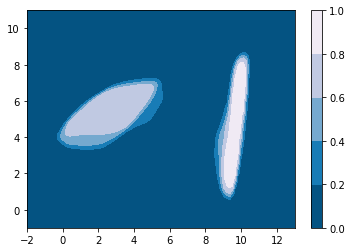

In [100]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 100
x = np.linspace(-2.0, 13.0, N)
y = np.linspace(-1.0, 11.0, N)

X, Y = np.meshgrid(x, y)

# A low hump with a spike coming out.
# Needs to have z/colour axis on a log scale so we see both hump and spike.
# linear scale only shows the spike.
#Z1 = np.exp(-X**2 - Y**2)
#Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
z = nn.Sigmoid()(netD(torch.Tensor(list(zip(X.reshape(-1), Y.reshape(-1))))).view(100, 100)).detach().numpy()

# Put in some negative values (lower left corner) to cause trouble with logs:
#z[:5, :5] = -0.1

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, locator=ticker.AutoLocator(), cmap=cm.PuBu_r)

# Alternatively, you can manually set the levels
# and the norm:
#lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
#levs = np.power(10, lev_exp)
#cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

cbar = fig.colorbar(cs)

plt.show()

In [163]:
torch.Tensor(list(zip(X.reshape(-1), Y.reshape(-1))))

tensor([[-3.0000, -2.0000],
        [-2.9394, -2.0000],
        [-2.8788, -2.0000],
        ...,
        [ 2.8788,  2.0000],
        [ 2.9394,  2.0000],
        [ 3.0000,  2.0000]])

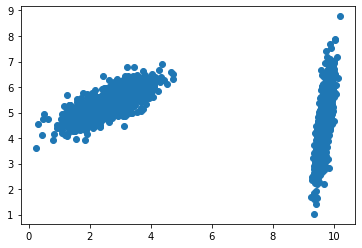

In [18]:
points = np.vstack((st.multivariate_normal.rvs(mean=mu1, cov=H1, size=1000), st.multivariate_normal.rvs(mean=mu2, cov=H2, size=1000)))
plt.scatter(points[:, 0], points[:, 1])

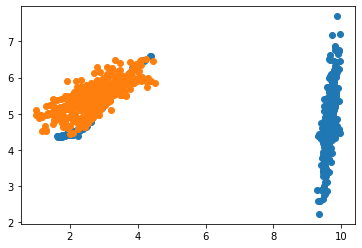

In [108]:
test_data1 = torch.Tensor(st.multivariate_normal.rvs(mean=mu1, cov=H1, size=1000))
test_data1 *= torch.rand(test_data1.shape).ge(0.5)
gen_data1 = netG(torch.cat((test_data1, torch.randn(1000, d)), dim=1)).detach().numpy()
test_data2 = torch.Tensor(st.multivariate_normal.rvs(mean=mu2, cov=H2, size=1000))
test_data2 *= torch.rand(test_data2.shape).ge(0.5)
gen_data2 = netG(torch.cat((test_data2, torch.randn(1000, d)), dim=1)).detach().numpy()
#points = np.vstack((st.multivariate_normal.rvs(mean=mu1, cov=H1, size=1000), st.multivariate_normal.rvs(mean=mu2, cov=H2, size=1000)))
plt.scatter(gen_data1[:, 0], gen_data1[:, 1])
plt.scatter(gen_data2[:, 0], gen_data2[:, 1])

In [242]:
netG(torch.cat((torch.Tensor([[0, 10]]), torch.randn(1, d)), dim=1))

tensor([[ 8.2834, 10.0965]], grad_fn=<AddmmBackward>)

array([4.22736046, 8.83698147])

In [3]:
from scipy import stats as st
import numpy as np
import torch
from torch import nn

In [4]:
D = 2 # размерность пространства объектов
d = 5 # размерность латентного пространства

In [5]:
mode_num = 10
mu = []
H = []
for i in range(mode_num):
    mu.append(np.random.random_sample(D) * 50) 
    H1 = np.random.random_sample((D, D))
    H1 = H1.T @ H1 + 0.01*np.eye(D)
    H.append(H1)

In [68]:
class Generator(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.block1 = nn.Sequential(
            nn.Linear(d+D, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()       
        )
        self.block2 = nn.Sequential(
            nn.Linear(d+D+256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()       
        )
        self.block3 = nn.Sequential(
            nn.Linear(d+D+512, D),
            #nn.Tanh()       
        )
    
    def forward(self, h0):
        h1 = torch.cat((h0, self.block1(h0)), dim=1)
        h2 = torch.cat((h1, self.block2(h1)), dim=1)
        return self.block3(h2)
        

class Discriminator(nn.Module):
    def __init__(self, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.D = D
        self.block1 = nn.Sequential(
            nn.Linear(D, 512),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        self.block2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        self.block3 = nn.Sequential(
            nn.Linear(512, 1),
            #nn.Sigmoid()         
        )
       
    def forward(self, h0):
        h1 = self.block1(h0)
        h2 = self.block2(h1)
        return self.block3(h2)
    
netG = Generator(d, D)
netD = Discriminator(D)

In [69]:
lr = 0.0005

# Initialize BCELoss function
criterion = nn.BCELoss()
criterion2 = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, d)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)

In [83]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, size):
        self.data = np.vstack([st.multivariate_normal.rvs(mean=mu[i], cov=H[i], size=size) for i in range(mode_num)]) 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
dataset = MyDataset(40000)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

In [84]:
clip = 0.5
def weight_clip(m):
    if type(m) == nn.Linear:
        with torch.no_grad():
            m.weight[m.weight > clip] = clip
            m.weight[m.weight < -clip] = -clip

In [139]:
num_epochs = 50
netD.train()
netG.train()

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.float()
        #print(real_data[0].dtype)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion2(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        #D_x = output.mean().item()

        if i % 10 == 0:
            ## Train with all-fake batch
            # Generate batch of latent vectors
            mask = torch.rand(data.shape).ge(0.5)
            masked_data = data.float() * mask
            noise = torch.randn(b_size, d) 
            # Generate fake image batch with G
            fake = netG(torch.cat((masked_data, noise), dim=1))
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion2(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
        
        if i % 2 == 0:
            label.fill_(fake_label)
            super_fake = torch.rand([b_size, D]) * 70 - 10
            output2 = netD(super_fake.detach()).view(-1)
            errD_super_fake = criterion2(output2, label)
            errD_super_fake.backward()        
        
        #D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake + errD_super_fake
        # Update D
        optimizerD.step()

        if i % 1 == 0:
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################            
            mask = torch.rand(data.shape).ge(0.5)
            masked_data = data.float() * mask
            noise = torch.randn(b_size, d) 
            # Generate fake image batch with G
            fake = netG(torch.cat((masked_data, noise), dim=1))
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion2(output, label)
            errG_gen = nn.L1Loss()(fake*mask, masked_data)
            errG += errG_gen
            # Calculate gradients for G
            errG.backward()
            #D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
        
            netD.apply(weight_clip)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            #with torch.no_grad():
                #fake = netG(fixed_noise).detach().cpu()
            #img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/196]	Loss_D: 1.5509	Loss_G: 1.6922
[0/50][50/196]	Loss_D: 1.7995	Loss_G: 1.6738
[0/50][100/196]	Loss_D: 1.9341	Loss_G: 1.4611
[0/50][150/196]	Loss_D: 1.9853	Loss_G: 1.4756
[1/50][0/196]	Loss_D: 1.9186	Loss_G: 1.5683
[1/50][50/196]	Loss_D: 1.8083	Loss_G: 1.6500
[1/50][100/196]	Loss_D: 1.9489	Loss_G: 1.6715
[1/50][150/196]	Loss_D: 2.0945	Loss_G: 1.8937
[2/50][0/196]	Loss_D: 1.8410	Loss_G: 1.5822
[2/50][50/196]	Loss_D: 1.8368	Loss_G: 1.5886
[2/50][100/196]	Loss_D: 1.9946	Loss_G: 1.5711
[2/50][150/196]	Loss_D: 1.9289	Loss_G: 1.6028
[3/50][0/196]	Loss_D: 1.9037	Loss_G: 1.6596
[3/50][50/196]	Loss_D: 2.0581	Loss_G: 1.5640
[3/50][100/196]	Loss_D: 1.9697	Loss_G: 1.7151
[3/50][150/196]	Loss_D: 1.8310	Loss_G: 1.5244
[4/50][0/196]	Loss_D: 1.8293	Loss_G: 1.6308
[4/50][50/196]	Loss_D: 2.0297	Loss_G: 1.7499
[4/50][100/196]	Loss_D: 1.9605	Loss_G: 1.6248
[4/50][150/196]	Loss_D: 2.0393	Loss_G: 1.6375
[5/50][0/196]	Loss_D: 1.7963	Loss_G: 1.5947
[5/50][50/196]	Loss_D: 1.

[44/50][100/196]	Loss_D: 1.9623	Loss_G: 1.5053
[44/50][150/196]	Loss_D: 2.0705	Loss_G: 1.5744
[45/50][0/196]	Loss_D: 1.9001	Loss_G: 1.5594
[45/50][50/196]	Loss_D: 2.0112	Loss_G: 1.5051
[45/50][100/196]	Loss_D: 1.9781	Loss_G: 1.4519
[45/50][150/196]	Loss_D: 1.8107	Loss_G: 1.5615
[46/50][0/196]	Loss_D: 1.8569	Loss_G: 1.6831
[46/50][50/196]	Loss_D: 1.9825	Loss_G: 1.6089
[46/50][100/196]	Loss_D: 1.9608	Loss_G: 1.5562
[46/50][150/196]	Loss_D: 1.9681	Loss_G: 1.8161
[47/50][0/196]	Loss_D: 1.8813	Loss_G: 1.4260
[47/50][50/196]	Loss_D: 2.0093	Loss_G: 1.5715
[47/50][100/196]	Loss_D: 1.9426	Loss_G: 1.5623
[47/50][150/196]	Loss_D: 1.9939	Loss_G: 1.4578
[48/50][0/196]	Loss_D: 1.8397	Loss_G: 1.3740
[48/50][50/196]	Loss_D: 1.9095	Loss_G: 1.6382
[48/50][100/196]	Loss_D: 2.1897	Loss_G: 1.5804
[48/50][150/196]	Loss_D: 2.0423	Loss_G: 1.6570
[49/50][0/196]	Loss_D: 1.9609	Loss_G: 1.6055
[49/50][50/196]	Loss_D: 1.9514	Loss_G: 1.4825
[49/50][100/196]	Loss_D: 1.8527	Loss_G: 1.6329
[49/50][150/196]	Loss_D: 1.8

In [140]:
netG.eval()
netD.eval()

Discriminator(
  (block1): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (block2): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (block3): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
  )
)

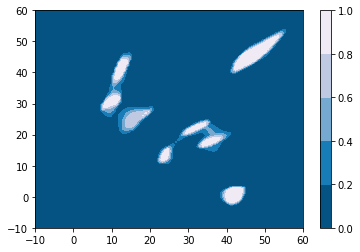

In [141]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 100
x = np.linspace(-10.0, 60.0, N)
y = np.linspace(-10.0, 60.0, N)

X, Y = np.meshgrid(x, y)

# A low hump with a spike coming out.
# Needs to have z/colour axis on a log scale so we see both hump and spike.
# linear scale only shows the spike.
#Z1 = np.exp(-X**2 - Y**2)
#Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
z = nn.Sigmoid()(netD(torch.Tensor(list(zip(X.reshape(-1), Y.reshape(-1))))).view(100, 100)).detach().numpy()

# Put in some negative values (lower left corner) to cause trouble with logs:
#z[:5, :5] = -0.1

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, locator=ticker.AutoLocator(), cmap=cm.PuBu_r)

# Alternatively, you can manually set the levels
# and the norm:
#lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
#levs = np.power(10, lev_exp)
#cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

cbar = fig.colorbar(cs)

plt.show()

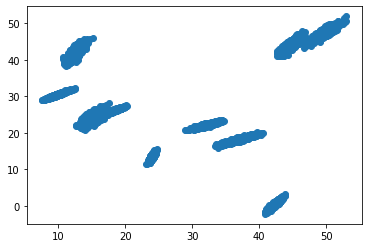

In [66]:
points = np.vstack([st.multivariate_normal.rvs(mean=mu[i], cov=H[i], size=1000) for i in range(mode_num)])
plt.scatter(points[:, 0], points[:, 1], )

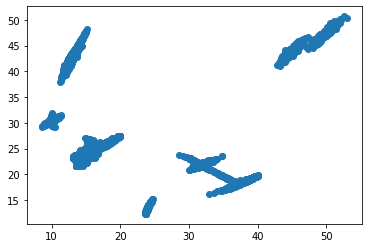

In [142]:
test_data = torch.cat([torch.Tensor(st.multivariate_normal.rvs(mean=mu[i], cov=H[i], size=1000)) for i in range(mode_num)])
test_data *= torch.rand(test_data.shape).ge(0.5)
gen_data = netG(torch.cat((test_data, torch.randn(1000*mode_num, d)), dim=1)).detach().numpy()
plt.scatter(gen_data[:, 0], gen_data[:, 1])